In [10]:
import sys
sys.path.append("../scripts")
from robot import *
import pandas as pd
from scipy.stats import multivariate_normal
import random,copy

In [15]:
class Mcl:
    
    def __init__(self,env_map,init_pose,num,
                 motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},
                 distance_dev_rate=0.14,direction_dev = 0.05):
        
        self.particles=[Particle(init_pose,1.0/num) for i in range(num)]
        self.map = env_map
        self.distance_dev_rate= distance_dev_rate
        self.direction_dev = direction_dev
        
        v= motion_noise_stds
        c= np.diag([v["nn"]**2,v["no"]**2,v["on"]**2,v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
        
        
    def motion_update(self, nu,omega, time):
        
        for p in self.particles:
            p.motion_update(nu,omega, time, self.motion_noise_rate_pdf)
    
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
        self.resampling()
    
    def resampling(self):
        ws =[e.weight for e in self.particles]
        if(sum(ws)<1e-100):
            ws=[e+1e-100 for e in ws]
        ps = random.choices(self.particles,weights = ws,k=len(self.particles))
        self.particles = [copy.deepcopy(e) for e in ps]
        for p in self.particles:
            p.weight = 1.0/len(self.particles)
    
    
    def draw(self,ax,elems):
        
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs=[math.cos(p.pose[2])*p.weight*len(self.particles) for p in self.particles]
        vys=[math.sin(p.pose[2])*p.weight*len(self.particles) for p in self.particles]
        elems.append(ax.quiver(xs,ys,vxs,vys,
                               angles="xy",scale_units="xy",scale=1.5,color="blue",alpha=0.5))
        

In [16]:
class EstimationAgent(Agent):
    def __init__(self,time_interval,nu,omega,estimator):
        super().__init__(nu,omega)
        self.time_interval= time_interval
        self.estimator = estimator
        self.prev_nu=0.0
        self.prev_omega=0.0
    
    def decision(self,observation=None):
        
        self.estimator.motion_update(self.prev_nu,self.prev_omega, self.time_interval)
        self.prev_nu,self.prev_omega = self.nu,self.omega
        self.estimator.observation_update(observation) # 追加
        return self.nu,self.omega
    
    
    def draw(self,ax,elems):
        self.estimator.draw(ax,elems)
        

In [17]:
class Particle:
    
    def __init__(self,init_pose,weight):
        self.pose = init_pose
        self.weight=weight
        
    def motion_update(self,nu,omega, time, noise_rate_pdf):
        
        ns =noise_rate_pdf.rvs()
        noised_nu =nu+ns[0]*math.sqrt(abs(nu)/time)+ns[1]*math.sqrt(abs(omega)/time)
        noised_omega =omega + ns[2]*math.sqrt(abs(nu)/time)+ns[3]*math.sqrt(abs(omega)/time)
        self.pose = VRobot.state_transition(noised_nu,noised_omega,time,self.pose)
    
    # この関数を追加
    def observation_update(self,observation,env_map,distance_dev_rate, direction_dev):
        for d in observation:
            obs_pos=d[0]
            obs_id =d[1]
            
            pos_on_map = env_map.landmarks[obs_id].pos
            particle_suggest_pos = VCamera.observation_function(self.pose, pos_on_map)
            
            distance_dev= distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2,direction_dev**2]))
            self.weight*= multivariate_normal(mean= particle_suggest_pos,cov=cov).pdf(obs_pos) 
            
    

<IPython.core.display.Javascript object>


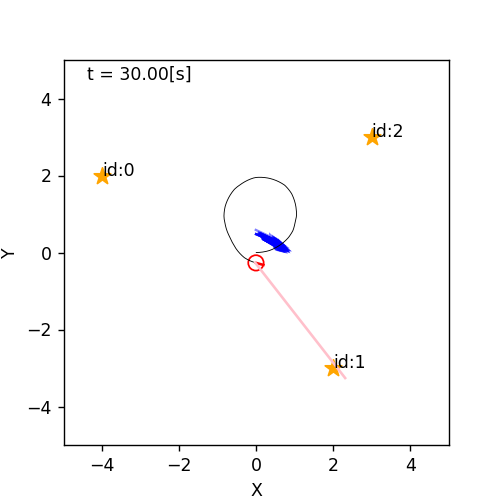

In [18]:
def trial():
    
    time_interval= 0.1
    world = VWorld(30,time_interval)
    
    m =Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)  
    
    initial_pose = np.array([0,0,0]).T
    estimator = Mcl(m,initial_pose, 100)
    circling =EstimationAgent(time_interval,0.2,10.0/180*math.pi,estimator)
    r= Robot(initial_pose,sensor=Camera(m),agent=circling,color="red")
    world.append(r)
    world.draw()
    
trial()

In [13]:
m = Map()
m.append_landmark(Landmark(1,0))

distance  = []
direction = []

for i in range(1000):
    c = Camera(m)
    d = c.data(np.array([0,0,0]).T)
    if(len(d)>0):
        distance.append(d[0][0][0])
        direction.append(d[0][0][1])

df = pd.DataFrame()
df["distance"] =distance
df["direction"] = direction
        
df

,distance,direction
0,1.080637,0.019712
1,0.780859,-0.050573
2,0.821505,-0.010941
3,0.594591,0.076739
4,0.916032,-0.053087
...,...,...
893,0.880697,0.021660
894,1.286968,-0.032117
895,1.154153,-0.029780
896,1.092137,0.088524


In [14]:
df.std()

distance     0.149290
direction    0.048522
dtype: float64

In [15]:
df.mean()

distance     1.002533
direction    0.001809
dtype: float64